In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('train.csv', index_col='id')
df.rename(columns={'timestamp' : 'date', 'price_doc' : 'target'}, inplace=True)
print('Rows:', df.shape[0], '\nColumns', df.shape[1])

Rows: 30471 
Columns 291


In [3]:
df.head()

,date,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,target
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30471 entries, 1 to 30473
Columns: 291 entries, date to target
dtypes: float64(119), int64(156), object(16)
memory usage: 67.9+ MB


In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
X_train = train.drop(['target', 'date'], axis=1)
y_train = train['target']
X_test = test.drop(['target', 'date'], axis=1)
y_test = test['target']

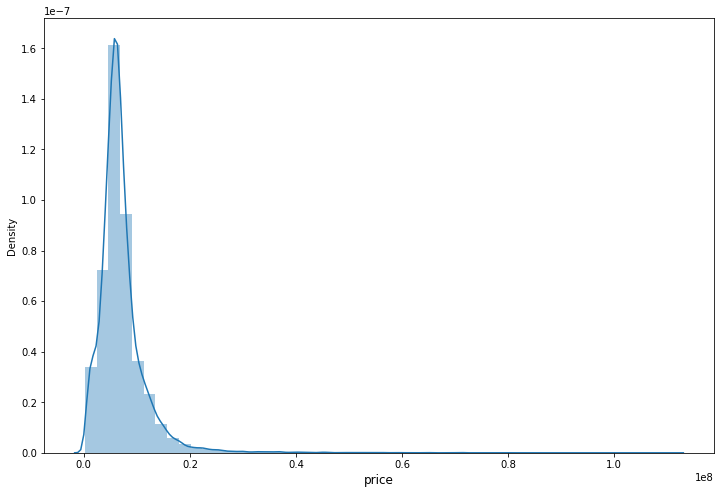

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(train['target'].values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

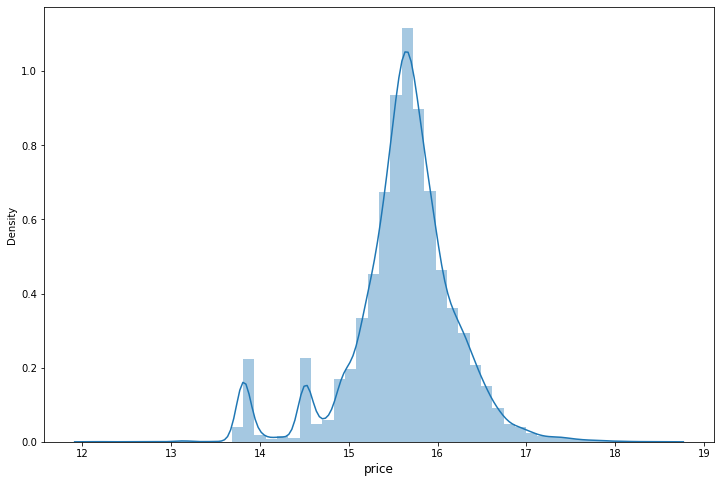

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(train['target'].values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

In [9]:
cat_features = list(X_train.select_dtypes(include=['object']).columns)
df[cat_features]

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
id,,,,,,,,,,,,,,,
1,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good
2,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent
3,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor
4,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good
5,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30469,Investment,Otradnoe,no,no,yes,no,yes,no,no,no,no,no,no,no,good
30470,Investment,Tverskoe,yes,no,no,no,yes,yes,no,no,yes,no,no,no,poor
30471,OwnerOccupier,Poselenie Vnukovskoe,no,no,no,no,no,no,no,no,no,no,no,no,no data


In [13]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

In [14]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
#         print(inputs.shape)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [15]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [18]:
def process_data(data):
    
    data = pd.get_dummies(data, columns=list(X_train.select_dtypes(include=['object']).columns))
#     data.loc[:, 'cp_time'] = data.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
#     data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})

# --------------------- Normalize ---------------------
#     for col in GENES:
#         data[col] = (data[col]-np.mean(data[col])) / (np.std(data[col]))
    
#     for col in CELLS:
#         data[col] = (data[col]-np.mean(data[col])) / (np.std(data[col]))
    
#--------------------- Removing Skewness ---------------------
#     for col in GENES + CELLS:
#         if(abs(data[col].skew()) > 0.75):
            
#             if(data[col].skew() < 0): # neg-skewness
#                 data[col] = data[col].max() - data[col] + 1
#                 data[col] = np.sqrt(data[col])
            
#             else:
#                 data[col] = np.sqrt(data[col])
    
    return data

In [17]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(X_train.columns)
num_targets=1
hidden_size=512

In [35]:
def run_training(X_train, y_train, X_valid, y_valid):
    
    X_train = process_data(X_train)
    y_train = process_data(y_train)
    X_valid = process_data(X_valid)
    y_valid = process_data(y_valid)
    
    X_train = X_train.reset_index(drop=True).values
    y_train = y_train.reset_index(drop=True).values
    X_valid = X_valid.reset_index(drop=True).values
    y_valid = y_valid.reset_index(drop=True).values
    
    train_dataset = MoADataset(X_train, y_train)
    valid_dataset = MoADataset(X_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_fn, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
#     x_test = test_[feature_cols].values
#     testdataset = TestDataset(x_test)
#     testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
#     model = Model(
#         num_features=num_features,
#         num_targets=num_targets,
#         hidden_size=hidden_size,
#     )
    
#     model.to(DEVICE)
    
#     predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
#     predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

In [36]:
oof_, pred_ = run_training(X_train, y_train, X_test, y_test)

RuntimeError: running_mean should contain 450 elements not 289

In [10]:
df['product_type'].value_counts()

Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64

In [11]:
clf = CatBoostRegressor(iterations=100, verbose=0)

In [12]:
clf.fit(X_train, y_train, cat_features=cat_features)

In [13]:
mean_squared_log_error(clf.predict(X_train), y_train)

0.20082116457362686

In [14]:
mean_squared_log_error(clf.predict(X_test), y_test)

0.21802379909033384

### Для kaggle

In [15]:
sub = pd.read_csv('test.csv', index_col='id').drop(['timestamp'], axis=1)
sub['product_type'].fillna('Missing', inplace=True)
sub.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
id,,,,,,,,,,,,,,,,,,,,,
30474,39.0,20.7,2,9,1,1998.0,1,8.9,3.0,Investment,...,8,0,0,0,1,10,1,0,14,1
30475,79.2,NaN,8,17,1,0.0,3,1.0,1.0,OwnerOccupier,...,4,1,1,0,2,11,0,1,12,1
30476,40.5,25.1,3,5,2,1960.0,2,4.8,2.0,Investment,...,42,11,4,0,10,21,0,10,71,11
30477,62.8,36.0,17,17,1,2016.0,2,62.8,3.0,OwnerOccupier,...,1,1,2,0,0,10,0,0,2,0
30478,40.0,40.0,17,17,1,0.0,1,1.0,1.0,OwnerOccupier,...,5,1,1,0,2,12,0,1,11,1


In [16]:
sub['price_doc'] = clf.predict(sub)

In [17]:
submission = pd.DataFrame(sub['price_doc'])
submission.to_csv('submission.csv')